In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
numLayer = 4
numQubit = 2
global iterations
global noisy

In [5]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 16):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

#unitary_param_1 = [0.83414377, 2.27238264, 5.8389326, 2.40918277, 4.47052641, 6.22458201, 1.97847354,
#                   1.89334833, 1.88614517, 4.82507852, 2.66745336, 1.38371607, 2.76324645, 3.93540582,
#                   0.71193782, 2.74935022]

In [6]:
print(unitary_param_1)

[3.81991143 0.16534047 4.30935126 1.26923455 2.93374382 0.93914128
 5.17541651 1.31614941 2.97381464 5.64546284 5.48792518 2.73798297
 0.72787378 5.53774438 2.46916687 0.42546023]


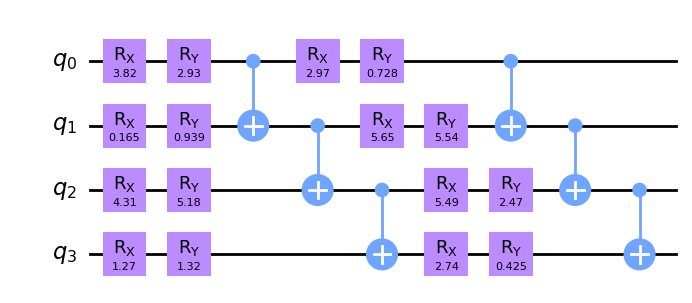

In [7]:
# First unitary
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

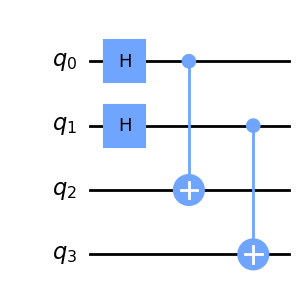

In [75]:
qcTest = QuantumCircuit(4)
qcTest.h(0)
qcTest.cx(0, 2)
qcTest.h(1)
qcTest.cx(1, 3)
qcTest.draw('mpl')

In [76]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [77]:
def createEqSuperposCS3():
    temp = QuantumCircuit(2)
    temp.h(0)
    temp.h(1)
    return temp

In [78]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(6)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCS3()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3, 4, 5])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [4, 5])
    
    circ.cswap(1, 2, 3)
    circ.cswap(1, 4, 5)
    
    circ.cx(1, 2)
    circ.cx(1, 4)
    
    circ.cx(0, 3)
    circ.cx(0, 5)
    
    circ.cx(0, 2)
    circ.cx(0, 4)
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

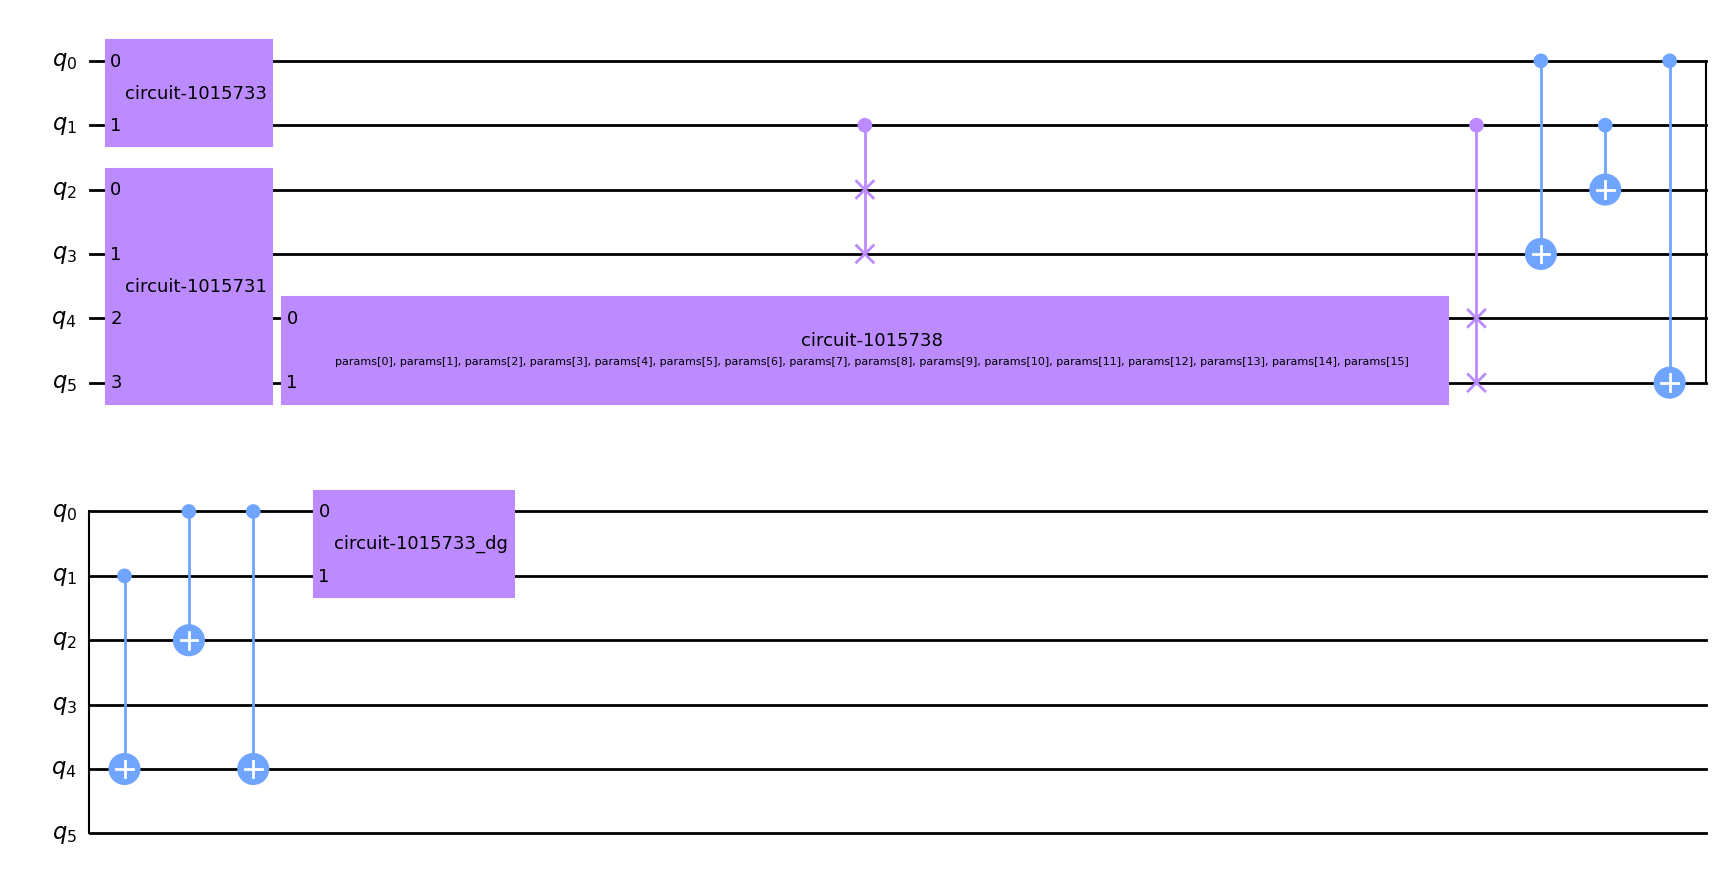

In [79]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [80]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [81]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [82]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [83]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [84]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [85]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [86]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15])])


In [87]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[3.22525864 2.30960081 5.45295708 0.77312554 5.14713346 0.2359096
 2.4779173  0.0730807  5.81213918 4.25486811 5.6356701  2.72253994
 0.26498469 0.85574996 2.82084752 5.89200861]
Initial Cost :  0.21338575319317377


In [88]:
true_value = 1.0

In [89]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.21338575319317377
Loss Value :  0.2904748016172745 1.0%
Loss Value :  0.29807799655750006 2.0%
Loss Value :  0.3105871696369914 3.0%
Loss Value :  0.31352372236003423 4.0%
Loss Value :  0.31413228134833143 5.0%
Loss Value :  0.32245134895587213 6.0%
Loss Value :  0.2797487899416162 7.0%
Loss Value :  0.5207496970734805 8.0%
Loss Value :  0.5207708605622667 9.0%
Loss Value :  0.3776455298210679 10.0%
Loss Value :  0.3793526619068128 11.0%
Loss Value :  0.3712838316253641 12.0%
Loss Value :  0.4141734200056134 13.0%
Loss Value :  0.42415634036739397 14.0%
Loss Value :  0.42017500144636705 15.0%
Loss Value :  0.42024422076756707 16.0%
Loss Value :  0.45436324535389444 17.0%
Loss Value :  0.4801172136985764 18.0%
Loss Value :  0.4764539710230497 19.0%
Loss Value :  0.4912121285242407 20.0%
Loss Value :  0.4791514322797414 21.0%
Loss Value :  0.43815175882081386 22.0%
Loss Value :  0.48382208213062433 23.0%
Loss Value :  0.48368647763693384 24.0%
Loss Value :  0.4847566095

In [90]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.22210909778252697
Loss Value :  0.24696288382050388 1.0%
Loss Value :  0.26285263612013143 2.0%
Loss Value :  0.20699160379271914 3.0%
Loss Value :  0.21528323079294795 4.0%
Loss Value :  0.3820373250351295 5.0%
Loss Value :  0.3441993409241277 6.0%
Loss Value :  0.43078791816942663 7.0%
Loss Value :  0.3623711802174393 8.0%
Loss Value :  0.36106507500656937 9.0%
Loss Value :  0.3158406274528494 10.0%
Loss Value :  0.3660911615980493 11.0%
Loss Value :  0.3690970763121225 12.0%
Loss Value :  0.3037389486322214 13.0%
Loss Value :  0.2970094453696156 14.0%
Loss Value :  0.41363737338207246 15.0%
Loss Value :  0.409241591361643 16.0%
Loss Value :  0.41984572205597415 17.0%
Loss Value :  0.4063124542944306 18.0%
Loss Value :  0.40734132305684495 19.0%
Loss Value :  0.41084109052584056 20.0%
Loss Value :  0.3978939913354459 21.0%
Loss Value :  0.42424210808698537 22.0%
Loss Value :  0.45730338718536245 23.0%
Loss Value :  0.47732569841723516 24.0%
Loss Value :  0.441046698

In [91]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9911841127772015


In [92]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.9992492709944716
Noisy :  0.760555627072676
Noise Resilient Value :  0.9911841127772015


In [55]:
def writeToFile():
    file = open("CS4_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [56]:
writeToFile()